#### Code for Validation Figure


### - This is a code to create a validation Figure for the Methods Section
####        - create S & T comparison for validation. It uses some code from Fig 2, but for different depths and also for salinity.


In [1]:
pwd

'/home/581/ns3783/Scripts/Figures'

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean.cm as cmocean
from collections import OrderedDict
import cartopy.crs as ccrs
import matplotlib.path as mpath
import cftime
from glob import glob
import dask
import os
import datetime
import matplotlib.colors as col
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as col
from scipy import interpolate


import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
# from cosima_cookbook import distributed as ccd

In [2]:
from dask.distributed import Client

print('starting distributed client...')
client = Client()
display(client)

starting distributed client...


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/44125/status,
Dashboard: /proxy/44125/status,Workers: 7
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43255,Workers: 7
Dashboard: /proxy/44125/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:46841,Total threads: 2
Dashboard: /proxy/38495/status,Memory: 9.00 GiB
Nanny: tcp://127.0.0.1:40831,


In [3]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
iaf_cycle3 = '01deg_jra55v140_iaf_cycle3'

##initially I calculated the model just for 2012, but after having a look on what sort of data the seals had, I decided to do all months from 2004-2018,
## so we would be covering the same period on both
first_year = '2004'
last_year = '2018'

start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

### Load temperature data at determined depth

In [4]:
# load temperature data at 100m:

# cut data for the extended area (Shack + Vincennes)
lat_slice  = slice(-75.5,-60)
lon_slice  = slice(-275, -230)

temp = cc.querying.getvar(iaf_cycle3,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_150m = temp.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=150,method='nearest')
temp_550m = temp.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=550,method='nearest')

# load data
temp_150m = temp_150m.load()
temp_550m = temp_550m.load()

In [5]:
#average for temperature 
temp_150m_avg = temp_150m.mean('time')
temp_550m_avg = temp_550m.mean('time')

### Load salinity data at determined depth

In [6]:
# load temperature data at 100m:

# cut data for the extended area (Shack + Vincennes)
lat_slice  = slice(-75.5,-60)
lon_slice  = slice(-275, -230)

sal = cc.querying.getvar(iaf_cycle3,'salt' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
sal_150m = sal.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=150,method='nearest')
sal_550m = sal.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice).sel(st_ocean=550,method='nearest')

# load data
sal_150m = sal_150m.load()
sal_550m = sal_550m.load()

In [7]:
#average for temperature 
sal_150m_avg = sal_150m.mean('time')
sal_550m_avg = sal_550m.mean('time')

### Bathymetry

In [9]:
# import bathymetry and the land/ocean mask to add to plot:
ht = cc.querying.getvar(iaf_cycle3,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# create land mask from the bathymetry:
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)]=1
land_mask = np.where(land_mask==1,land_mask,np.nan)

### SKIP TO "OPEN DATA" IF YOU'VE DONE THIS PART ALREADY

#### LOAD SEALS 

In [10]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

start_time='2150-01-01'
end_time='2159-12-31'

lon_slice  = slice(-255, -247)
lat_slice  = slice(-75.5,-60)

In [11]:
# topography data:
ht = cc.querying.getvar(control,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

# bottom cell indices:
kmt = cc.querying.getvar(control,'kmt',master_session, n=-1)
kmt = kmt.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
kmt = kmt.fillna(1.0).astype(int) - 1
kmt.load()

fontsize=16

## Get model grid data and temperature climatology:

In [12]:
# for comparing seal data to IAF:
iaf = '01deg_jra55v140_iaf_cycle3'

start_time='2012-01-01'
end_time='2012-12-31'

temp_con = cc.querying.getvar(iaf,'temp', master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_con = temp_con.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)                          
#temp_con = temp_con.sel(time=slice(start_time,end_time)).groupby('time.month').mean('time')
temp_con = temp_con[:,:50,:,:]
temp_con = temp_con.load()

Exception during reset or similar
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 697, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 893, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/sqlalchemy/engine/default.py", line 558, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 23339242039104 and this is thread id 23336322209536.
Exception closing connection <sqlite3.Connection object at 0x1539685e33f0>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.04/lib/python3.9/site-packages/sqlalchemy/pool/b

In [13]:
xt_ocean = temp_con.xt_ocean
yt_ocean = temp_con.yt_ocean
st_ocean = temp_con.st_ocean

## Select out profiles in correct region:

#### Improvements on this figure: take out winter profiles, sort profiles 
#### Fix it in a way they don't go much shallower than 400m. 

In [14]:
%%time

# do some testing to see which seal data is in the right region:
# Need to consider profiles from Brazil, Germany, UK, USA
# I think the interpolated data is fine to use here, because I only want profiles < 1000m.

path2files   = '/g/data/jk72/ns3783/seal_data/'
FileList = glob(path2files+'*.nc')
FileList.sort()

WAP_FileList = []
for file in FileList:
    # open all profiles for this seal:
    profile_data = xr.open_dataset(file)
    lat = profile_data.LATITUDE
    lon = profile_data.LONGITUDE
    # check if in West Antarctic Peninsula box:
    WAP_box=lat.where(lon>104).where(lon<114).where(lat<-60).dropna(dim='N_PROF')
    if len(WAP_box)>0:
        WAP_FileList += [file]

CPU times: user 22.9 s, sys: 5.44 s, total: 28.3 s
Wall time: 1min 31s


In [15]:
np.shape(WAP_FileList)

(58,)

In [17]:
%%time

# Now go through the profiles in the WAP box and select out all profiles on the shelf:

nprofiles = 29496 # tested with one run / so this is all good. I know this is the right number for this dataset
ndepth = 1000 #although I have downloaded the profiles with no interpolation, some might have been interpolated because it doesn't run with less than 1000 levels
temp = np.zeros((nprofiles,ndepth))
pres = np.zeros((nprofiles,ndepth))
sal = np.zeros((nprofiles,ndepth))

temp_0 = np.zeros((nprofiles,1)) #the next 2 lines were experiments. 
pres_0 = np.zeros((nprofiles,1))
temp_100 = np.zeros((nprofiles,1)) #the next 2 lines were experiments. 
pres_100 = np.zeros((nprofiles,1))
temp_300 = np.zeros((nprofiles,1)) #the next 2 lines were experiments. 
pres_300 = np.zeros((nprofiles,1))
temp_500 = np.zeros((nprofiles,1)) #the next 2 lines were experiments. 
pres_500 = np.zeros((nprofiles,1))

sal_0 = np.zeros((nprofiles,1)) 
sal_100 = np.zeros((nprofiles,1)) 
sal_300 = np.zeros((nprofiles,1)) 
sal_500 = np.zeros((nprofiles,1)) 

lon_obs = np.zeros((nprofiles))
lat_obs = np.zeros((nprofiles))
date = []
#date_obs = np.zeros((nprofiles)) 
year_obs = np.zeros((nprofiles))
month_obs = np.zeros((nprofiles))

profile_count = 0

for file in WAP_FileList:
    # open all profiles for this seal:
    profile_data = xr.open_dataset(file)
    lat = profile_data.LATITUDE
    lon = profile_data.LONGITUDE
    juld = profile_data.JULD
    # go through each profile and find nearest model grid point:
    for profile in range(len(lat)):
        # NOTE THAT LONGITUDE IS NOT ADJUSTED FOR THE MODEL RANGE HERE, BECAUSE RANGE ON PENINSULA IS OK
        # BUT THIS WILL NOT WORK ELSEWHERE!!
        temp_profile = profile_data.TEMP_ADJUSTED[profile]
        sal_profile = profile_data.PSAL_ADJUSTED[profile]
        if len(np.where((temp_profile!=0.)&(~np.isnan(temp_profile)))[0]) > 2:
            # check the dive reached at least 200 dbar:
            pres_profile = profile_data.PRES_ADJUSTED[profile]
            if pres_profile.max() > 200:
                date = np.append(date,profile_data.JULD[profile])
                #date_obs[profile_count] = date[profile]
                year_obs[profile_count] = profile_data.JULD[profile].dt.year #this is an add on to lock months and years separately
                month_obs[profile_count] = profile_data.JULD[profile].dt.month
                # save profile:
                lat_obs[profile_count] = lat[profile]
                lon_obs[profile_count] = lon[profile]
                # find depth of profile:
                nlevels = len(profile_data.PRES_ADJUSTED[profile])
                temp[profile_count,:nlevels] = temp_profile
                pres[profile_count,:nlevels] = pres_profile
                sal[profile_count,:nlevels] = sal_profile
                #save them with the closest number to 0
                array = np.asarray(pres_profile)
                idx = (np.abs(array - 0)).argmin()
                temp_0[profile_count,:] = temp_profile[idx]
                pres_0[profile_count,:] = pres_profile[idx]
                sal_0[profile_count,:] = sal_profile[idx]
                
                #save them with the closest number to 100
                array = np.asarray(pres_profile)
                idx = (np.abs(array - 100)).argmin()
                temp_100[profile_count,:] = temp_profile[idx]
                pres_100[profile_count,:] = pres_profile[idx]
                sal_100[profile_count,:] = sal_profile[idx]
                
                #save them with the closest number to 300
                array = np.asarray(pres_profile)
                idx = (np.abs(array - 300)).argmin()
                temp_300[profile_count,:] = temp_profile[idx]
                pres_300[profile_count,:] = pres_profile[idx]
                sal_300[profile_count,:] = sal_profile[idx]
                
                #save them with the closest number to 500
                array = np.asarray(pres_profile)
                idx = (np.abs(array - 500)).argmin()
                temp_500[profile_count,:] = temp_profile[idx]
                pres_500[profile_count,:] = pres_profile[idx]
                sal_500[profile_count,:] = sal_profile[idx]
                
                # all levels?
                temp[profile_count,:nlevels] = temp_profile
                sal[profile_count,:nlevels] = sal_profile
                pres[profile_count,:nlevels] = pres_profile
                profile_count += 1

CPU times: user 4min 25s, sys: 25.6 s, total: 4min 51s
Wall time: 4min 23s


## Interpolate MEOP profiles onto model depth grid and convert to conservative temp:


In [19]:
# convert to absolute salinity:
from gsw import SA_from_SP
salt_abs = SA_from_SP(sal,pres,np.tile(lon_obs,(ndepth,1)).swapaxes(0,1),np.tile(lat_obs,(ndepth,1)).swapaxes(0,1))

In [20]:
# convert to conservative temp:
from gsw import CT_from_t
temp_conservative = CT_from_t(salt_abs,temp,pres)

In [21]:
# convert pressure to depth:
from gsw import z_from_p
z = -z_from_p(pres,np.tile(lat_obs,(ndepth,1)).swapaxes(0,1))

### Interpolating the seal data to the model grid. >> this is working know, but I am not sure what exactly I have done that got it right. 

In [22]:
%%time
# Only care about on shelf, so just do top 50 levels:
temp_interp = np.zeros((nprofiles,50))
sal_interp = np.zeros((nprofiles,50))

for profile in range(nprofiles):
    # select out available pressure range of data:
    pres_profile = pres[profile,:][pres[profile,:]>0]
    temp_profile = temp_conservative[profile,:][pres[profile,:]>0]
    sal_profile = sal[profile,:][pres[profile,:]>0]
    # also remove missing temperature points:
    temp_profile_adj = temp_profile[temp_profile!=0]
    pres_profile_adj = pres_profile[temp_profile!=0]
    sal_profile_adj = sal_profile[temp_profile!=0]
    
    f = interpolate.interp1d(pres_profile,temp_profile,bounds_error=False)
    temp_interp[profile,:] = f(st_ocean)
    
    f = interpolate.interp1d(pres_profile,sal_profile,bounds_error=False)
    sal_interp[profile,:] = f(st_ocean)

CPU times: user 14.5 s, sys: 1.19 s, total: 15.7 s
Wall time: 14.6 s


### check how those profles are looking

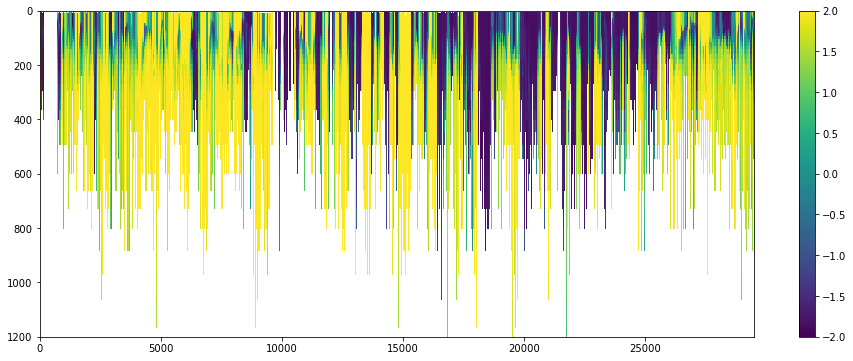

In [23]:
# check temp profiles look ok:
x_2d,y_2d = np.meshgrid(np.arange(nprofiles),st_ocean)

plt.figure(figsize=(16,6))
plt.pcolormesh(x_2d,y_2d,temp_interp.swapaxes(0,1))
plt.ylim(1200,0)
plt.colorbar()
plt.clim(-2,2)

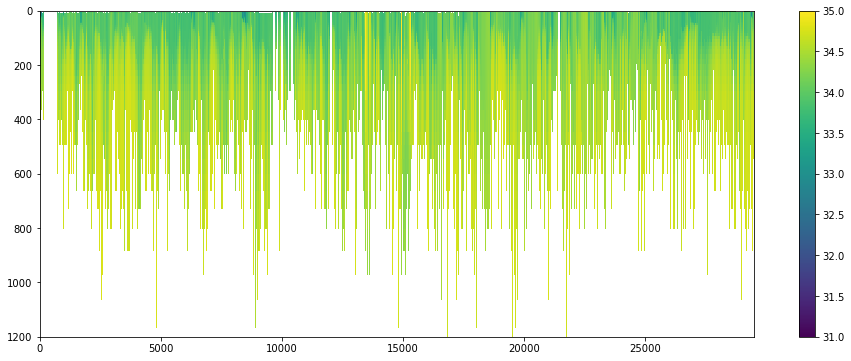

In [24]:
# check sal profiles look ok:
x_2d,y_2d = np.meshgrid(np.arange(nprofiles),st_ocean)

plt.figure(figsize=(16,6))
plt.pcolormesh(x_2d,y_2d,sal_interp.swapaxes(0,1))
plt.ylim(1200,0)
plt.colorbar()
plt.clim(31,35)

### saving data

In [25]:
temp_interp = xr.DataArray(temp_interp, coords = [np.arange(nprofiles), st_ocean], dims = ['profile_number', 'st_ocean'], name = 'seal profiles interpolated onto model depth grid')
sal_interp = xr.DataArray(sal_interp, coords = [np.arange(nprofiles), st_ocean], dims = ['profile_number', 'st_ocean'], name = 'seal profiles interpolated onto model depth grid')
lon_obs = xr.DataArray(lon_obs, coords = [np.arange(nprofiles)], dims = ['profile_number'], name = 'longitude of seal profiles')
lat_obs = xr.DataArray(lat_obs, coords = [np.arange(nprofiles)], dims = ['profile_number'], name = 'latitude of seal profiles')
month_obs = xr.DataArray(month_obs, coords = [np.arange(nprofiles)], dims = ['profile_number'], name = 'month of seal profiles')
year_obs = xr.DataArray(year_obs, coords = [np.arange(nprofiles)], dims = ['profile_number'], name = 'year of seal profiles')
date = xr.DataArray(date, coords = [np.arange(nprofiles)], dims = ['profile_number'], name = 'date of seal profiles')

ds = xr.Dataset({'temp_interp': temp_interp,'sal_interp': sal_interp, 'lon_obs':lon_obs,'lat_obs':lat_obs,'month_obs':month_obs,'year_obs':year_obs,'date':date})
outpath = '/g/data/v45/ns3783/VB_MEOP_profiles_interpolated_sal&T.nc'
ds.to_netcdf(outpath)

## Open saved seal data:

In [26]:
outpath = '/g/data/v45/ns3783/VB_MEOP_profiles_interpolated_sal&T.nc'
profile_data = xr.open_dataset(outpath)
lat_obs = profile_data.lat_obs
lon_obs = profile_data.lon_obs
month_obs = profile_data.month_obs
year_obs = profile_data.year_obs
temp_interp = profile_data.temp_interp
sal_interp = profile_data.sal_interp
date = profile_data.date

# need to assign lat/lon coords for binning:
temp_interp = temp_interp.assign_coords({'lon':lon_obs,'lat':lat_obs})
sal_interp = sal_interp.assign_coords({'lon':lon_obs,'lat':lat_obs})

In [27]:
np.unique(year_obs)

array([2004., 2005., 2007., 2008., 2009., 2010., 2011., 2012., 2013.,
       2014., 2015., 2016., 2017., 2018., 2019.])

## PLOT T & SALT to see if all is good

#### Here I played around a little to decide which slices to choose. Whatever you decide here, you have to go and change the slices you load from the model at the beginning

Text(0.5, 0, 'Longitude')

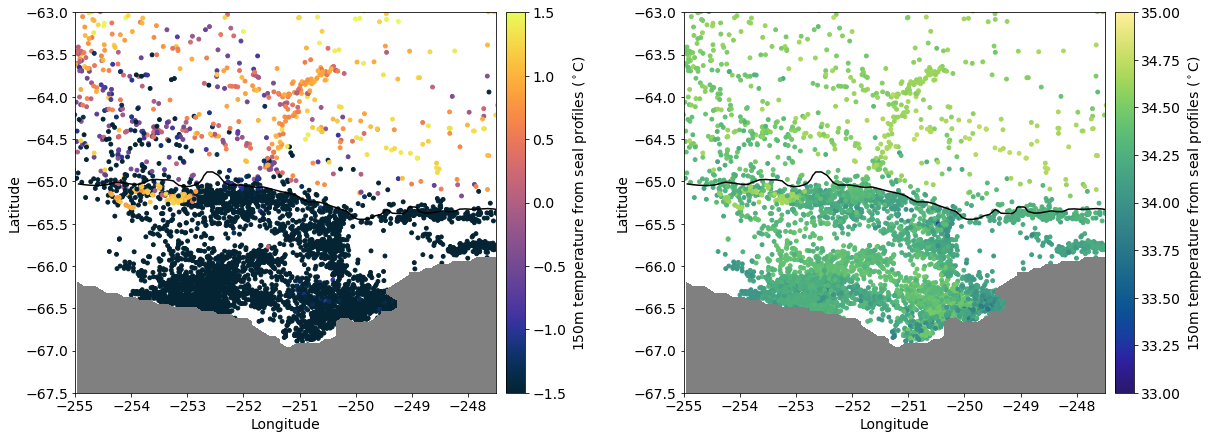

In [28]:
# plot 200m slice:
fontsize = 14
depth_slice = 150

plt.figure(figsize=(20,7))
plt.subplot(1, 2, 1)
sc = plt.scatter(lon_obs-360,lat_obs,c=temp_interp.sel(st_ocean=depth_slice,method='nearest'),s=15,cmap=cmocean.thermal,vmin=-1.5,vmax=1.5)
cbar = plt.colorbar(sc, orientation = 'vertical',extend = 'neither',pad=.02)
cbar.set_label(str(depth_slice)+'m temperature from seal profiles ($^\circ$C)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k')
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.ylim((-67.5, -63))
plt.xlim((-255, -247.5))
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
plt.xlabel('Longitude',fontsize=fontsize)

plt.subplot(1, 2, 2)
sc = plt.scatter(lon_obs-360,lat_obs,c=sal_interp.sel(st_ocean=depth_slice,method='nearest'),s=15,cmap=cmocean.haline,vmin=33,vmax=35)
cbar = plt.colorbar(sc, orientation = 'vertical',extend = 'neither',pad=.02)
cbar.set_label(str(depth_slice)+'m temperature from seal profiles ($^\circ$C)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k')
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.ylim((-67.5, -63))
plt.xlim((-255, -247.5))
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
plt.xlabel('Longitude',fontsize=fontsize)
#figure_path = figdir+'/seal_temp_map_'+str(depth_slice)+'m.png'
#plt.savefig(figure_path, dpi=120,bbox_inches='tight', pad_inches=0.1,facecolor='white')

## Bin seal data into lat/lon bins:
### that is because they are a bit on top of one another and my attempt at sortng failed.

In [29]:
# set up new bins:
lon_bins = np.arange(104, 114, .1)
lat_bins = np.arange(-76, -60, .1) 

lon_mid = (lon_bins[1:] + lon_bins[:-1])/2
lat_mid = (lat_bins[1:] + lat_bins[:-1])/2

### depth = 150* we can define these depths at the top, by checking the data before bining on the plot above. I have previously chosen 4 depths (see validation_figure.ipynd) and have then reduced to this 

In [30]:
## just do for a single depth slice:
depth = 150
temp_slice = temp_interp.sel(st_ocean=depth,method='nearest')
sal_slice = sal_interp.sel(st_ocean=depth,method='nearest')
# single slice:
binned_meop_temp150 = xr.DataArray(np.zeros((len(lat_bins)-1, len(lon_bins)-1)), coords = [lat_mid, lon_mid], 
                                dims = ['lat_bin', 'lon_bin'], name = 'binned meop temperature data')
binned_meop_sal150 = xr.DataArray(np.zeros((len(lat_bins)-1, len(lon_bins)-1)), coords = [lat_mid, lon_mid], 
                                dims = ['lat_bin', 'lon_bin'], name = 'binned meop salinity data')
# full depth:
#binned_meop_temp = xr.DataArray(np.zeros((len(st_ocean),len(lat_bins)-1, len(lon_bins)-1)), coords = [st_ocean,lat_mid, lon_mid], 
#                                dims = ['st_ocean','lat_bin', 'lon_bin'], name = 'binned meop temperature data')
                                                      
for i in range(len(lon_bins)-1):
    #if i%50 == 0:
    print('lon bin '+str(i)+'/'+str(len(lon_bins)-1))
    for j in range(len(lat_bins)-1):
        bin_mask = temp_slice.where(temp_slice.lon <= lon_bins[i+1]).where(temp_slice.lon > lon_bins[i])\
            .where(temp_slice.lat <= lat_bins[j+1]).where(temp_slice.lat > lat_bins[j]) * 0 + 1
        binned_meop_temp150[j,i] = (temp_slice * bin_mask).mean(dim = 'profile_number')
        binned_meop_sal150[j,i] = (sal_slice * bin_mask).mean(dim = 'profile_number')
        #binned_meop_temp[:,j,i] = (temp_interp * bin_mask).mean(dim = 'profile_number')

lon bin 0/99
lon bin 1/99
lon bin 2/99
lon bin 3/99
lon bin 4/99
lon bin 5/99
lon bin 6/99
lon bin 7/99
lon bin 8/99
lon bin 9/99
lon bin 10/99
lon bin 11/99
lon bin 12/99
lon bin 13/99
lon bin 14/99
lon bin 15/99
lon bin 16/99
lon bin 17/99
lon bin 18/99
lon bin 19/99
lon bin 20/99
lon bin 21/99
lon bin 22/99
lon bin 23/99
lon bin 24/99
lon bin 25/99
lon bin 26/99
lon bin 27/99
lon bin 28/99
lon bin 29/99
lon bin 30/99
lon bin 31/99
lon bin 32/99
lon bin 33/99
lon bin 34/99
lon bin 35/99
lon bin 36/99
lon bin 37/99
lon bin 38/99
lon bin 39/99
lon bin 40/99
lon bin 41/99
lon bin 42/99
lon bin 43/99
lon bin 44/99
lon bin 45/99
lon bin 46/99
lon bin 47/99
lon bin 48/99
lon bin 49/99
lon bin 50/99
lon bin 51/99
lon bin 52/99
lon bin 53/99
lon bin 54/99
lon bin 55/99
lon bin 56/99
lon bin 57/99
lon bin 58/99
lon bin 59/99
lon bin 60/99
lon bin 61/99
lon bin 62/99
lon bin 63/99
lon bin 64/99
lon bin 65/99
lon bin 66/99
lon bin 67/99
lon bin 68/99
lon bin 69/99
lon bin 70/99
lon bin 71/99
lo

### depth = 550 

In [31]:
## just do for a single depth slice:
depth = 550
temp_slice = temp_interp.sel(st_ocean=depth,method='nearest')
sal_slice = sal_interp.sel(st_ocean=depth,method='nearest')
# single slice:
binned_meop_temp550 = xr.DataArray(np.zeros((len(lat_bins)-1, len(lon_bins)-1)), coords = [lat_mid, lon_mid], 
                                dims = ['lat_bin', 'lon_bin'], name = 'binned meop temperature data')
binned_meop_sal550 = xr.DataArray(np.zeros((len(lat_bins)-1, len(lon_bins)-1)), coords = [lat_mid, lon_mid], 
                                dims = ['lat_bin', 'lon_bin'], name = 'binned meop salinity data')
# full depth:
#binned_meop_temp = xr.DataArray(np.zeros((len(st_ocean),len(lat_bins)-1, len(lon_bins)-1)), coords = [st_ocean,lat_mid, lon_mid], 
#                                dims = ['st_ocean','lat_bin', 'lon_bin'], name = 'binned meop temperature data')
                                                      
for i in range(len(lon_bins)-1):
    #if i%50 == 0:
    print('lon bin '+str(i)+'/'+str(len(lon_bins)-1))
    for j in range(len(lat_bins)-1):
        bin_mask = temp_slice.where(temp_slice.lon <= lon_bins[i+1]).where(temp_slice.lon > lon_bins[i])\
            .where(temp_slice.lat <= lat_bins[j+1]).where(temp_slice.lat > lat_bins[j]) * 0 + 1
        binned_meop_temp550[j,i] = (temp_slice * bin_mask).mean(dim = 'profile_number')
        binned_meop_sal550[j,i] = (sal_slice * bin_mask).mean(dim = 'profile_number')
        #binned_meop_temp[:,j,i] = (temp_interp * bin_mask).mean(dim = 'profile_number')

lon bin 0/99
lon bin 1/99
lon bin 2/99
lon bin 3/99
lon bin 4/99
lon bin 5/99
lon bin 6/99
lon bin 7/99
lon bin 8/99
lon bin 9/99
lon bin 10/99
lon bin 11/99
lon bin 12/99
lon bin 13/99
lon bin 14/99
lon bin 15/99
lon bin 16/99
lon bin 17/99
lon bin 18/99
lon bin 19/99
lon bin 20/99
lon bin 21/99
lon bin 22/99
lon bin 23/99
lon bin 24/99
lon bin 25/99
lon bin 26/99
lon bin 27/99
lon bin 28/99
lon bin 29/99
lon bin 30/99
lon bin 31/99
lon bin 32/99
lon bin 33/99
lon bin 34/99
lon bin 35/99
lon bin 36/99
lon bin 37/99
lon bin 38/99
lon bin 39/99
lon bin 40/99
lon bin 41/99
lon bin 42/99
lon bin 43/99
lon bin 44/99
lon bin 45/99
lon bin 46/99
lon bin 47/99
lon bin 48/99
lon bin 49/99
lon bin 50/99
lon bin 51/99
lon bin 52/99
lon bin 53/99
lon bin 54/99
lon bin 55/99
lon bin 56/99
lon bin 57/99
lon bin 58/99
lon bin 59/99
lon bin 60/99
lon bin 61/99
lon bin 62/99
lon bin 63/99
lon bin 64/99
lon bin 65/99
lon bin 66/99
lon bin 67/99
lon bin 68/99
lon bin 69/99
lon bin 70/99
lon bin 71/99
lo

In [32]:
#testing 
binned_meop_temp150.lon_bin

<xarray.DataArray 'lon_bin' (lon_bin: 99)>
array([104.05, 104.15, 104.25, 104.35, 104.45, 104.55, 104.65, 104.75, 104.85,
       104.95, 105.05, 105.15, 105.25, 105.35, 105.45, 105.55, 105.65, 105.75,
       105.85, 105.95, 106.05, 106.15, 106.25, 106.35, 106.45, 106.55, 106.65,
       106.75, 106.85, 106.95, 107.05, 107.15, 107.25, 107.35, 107.45, 107.55,
       107.65, 107.75, 107.85, 107.95, 108.05, 108.15, 108.25, 108.35, 108.45,
       108.55, 108.65, 108.75, 108.85, 108.95, 109.05, 109.15, 109.25, 109.35,
       109.45, 109.55, 109.65, 109.75, 109.85, 109.95, 110.05, 110.15, 110.25,
       110.35, 110.45, 110.55, 110.65, 110.75, 110.85, 110.95, 111.05, 111.15,
       111.25, 111.35, 111.45, 111.55, 111.65, 111.75, 111.85, 111.95, 112.05,
       112.15, 112.25, 112.35, 112.45, 112.55, 112.65, 112.75, 112.85, 112.95,
       113.05, 113.15, 113.25, 113.35, 113.45, 113.55, 113.65, 113.75, 113.85])
Coordinates:
  * lon_bin  (lon_bin) float64 104.0 104.1 104.2 104.3 ... 113.6 113.7 113.8

## PLOT of BINNED temp and sal to test

Text(0.5, 0, 'Longitude')

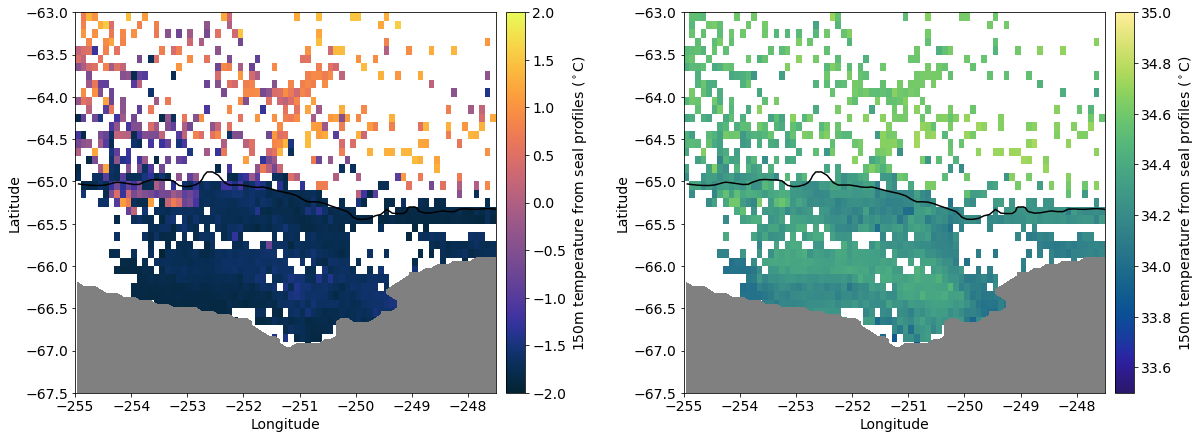

In [33]:
# plot 200m slice:
fontsize = 14
depth_slice = 150

plt.figure(figsize=(20,7))
plt.subplot(1, 2, 1)
sc=plt.pcolormesh(binned_meop_temp150.lon_bin-360,binned_meop_temp150.lat_bin,binned_meop_temp150,cmap=cmocean.thermal,vmin=-2,vmax=2)
cbar = plt.colorbar(sc, orientation = 'vertical',extend = 'neither',pad=.02)
cbar.set_label(str(depth_slice)+'m temperature from seal profiles ($^\circ$C)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k')
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.ylim((-67.5, -63))
plt.xlim((-255, -247.5))
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
plt.xlabel('Longitude',fontsize=fontsize)

plt.subplot(1, 2, 2)
sc=plt.pcolormesh(binned_meop_sal150.lon_bin-360,binned_meop_sal150.lat_bin,binned_meop_sal150,cmap=cmocean.haline,vmin=33.5,vmax=35)
cbar = plt.colorbar(sc, orientation = 'vertical',extend = 'neither',pad=.02)
cbar.set_label(str(depth_slice)+'m temperature from seal profiles ($^\circ$C)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k')
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.ylim((-67.5, -63))
plt.xlim((-255, -247.5))
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
plt.xlabel('Longitude',fontsize=fontsize)

#figure_path = figdir+'/seal_temp_map_'+str(depth_slice)+'m.png'
#plt.savefig(figure_path, dpi=120,bbox_inches='tight', pad_inches=0.1,facecolor='white')

### Unite both plots

### Temperature validation

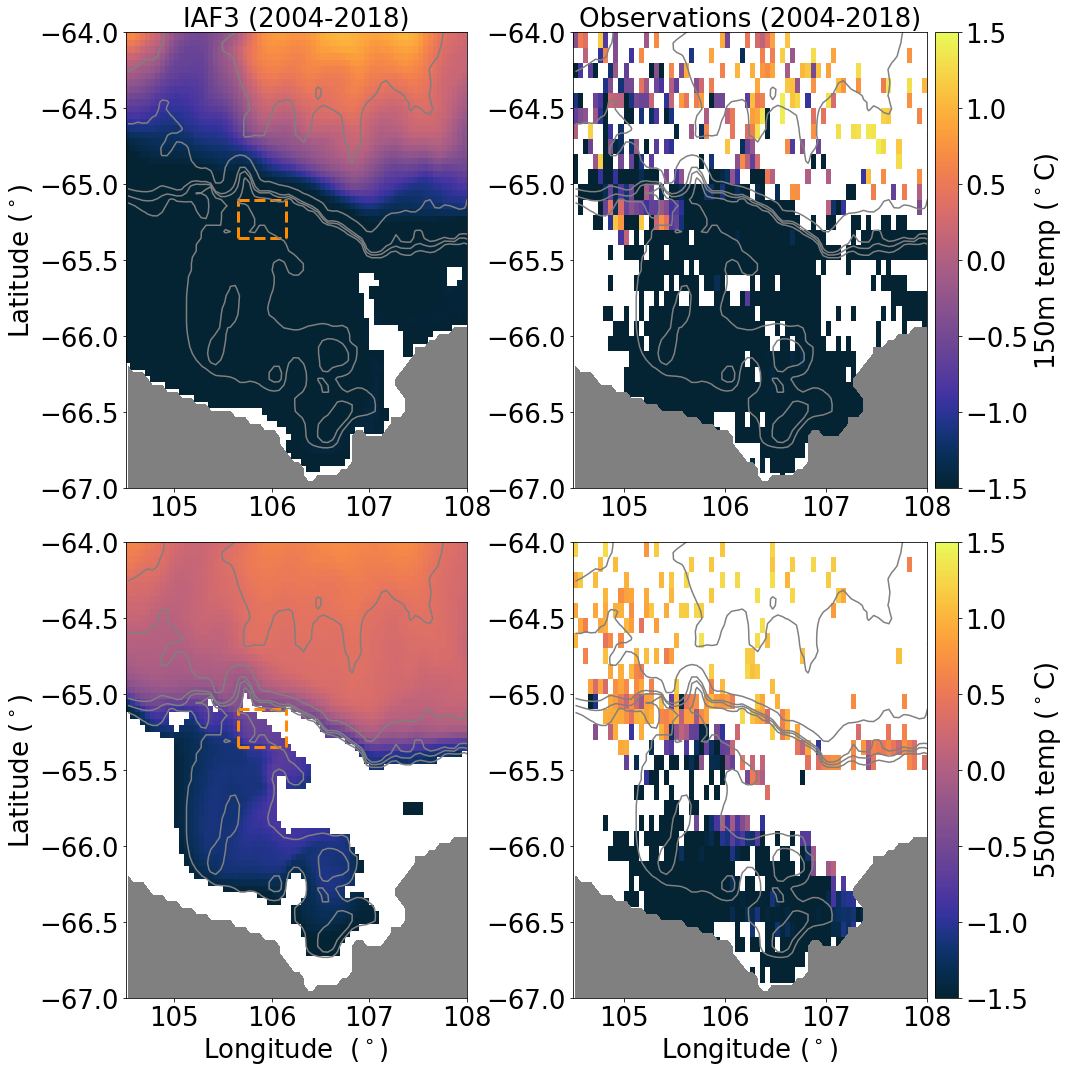

In [35]:
#Prepping variables to plot
fontsize=26

fig=plt.figure(figsize=(15, 15))
fig.subplots_adjust(top=0.88)
    
ax0=plt.subplot(2,2,1)   
depth_slice = 150
pc = plt.pcolormesh(temp_150m_avg.xt_ocean,temp_150m_avg.yt_ocean,
                        temp_150m_avg, cmap = cmocean.thermal, 
                        vmin=-1.5,vmax=1.5)
plt.plot([-252.7,-252.7],[-65.35, -65.1],color='darkorange',linestyle='--',linewidth=3)
plt.plot([-251.7,-251.7],[-65.35, -65.1],color='darkorange',linestyle='--',linewidth=3)
plt.plot([-252.7,-251.7],[-65.1, -65.1],color='darkorange',linestyle='--',linewidth=3)
plt.plot([-252.7,-251.7],[-65.35, -65.35],color='darkorange',linestyle='--',linewidth=3)

#plt.title('Model (2004-2018)',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[600,800,1000,2000,3000],colors='gray',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.title('IAF3 (2004-2018)',fontsize=fontsize)
#plt.xlabel('Longitude  ($^\circ$)',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -248))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(str(depth_slice)+'m temperature from IAF3 ($^\circ$C)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-253+359,-252+359,-251+359,-250+359,-249+359,-248+359])

ax1=plt.subplot(2,2,2)    

sc=plt.pcolormesh(binned_meop_temp150.lon_bin-360,binned_meop_temp150.lat_bin,binned_meop_temp150,cmap=cmocean.thermal,vmin=-1.5,vmax=1.5)
cbar = plt.colorbar(sc, orientation = 'vertical',extend = 'neither',pad=.02)
cbar.set_label(str(depth_slice)+'m temp ($^\circ$C)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)
#plt.title('Observations (2004-2019)',fontsize=fontsize)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[600,800,1000,2000,3000],colors='gray')
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.ylim((-67, -64))
plt.xlim((-255, -248))
plt.tick_params(labelsize=fontsize)
plt.title('Observations (2004-2018)',fontsize=fontsize)
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
#plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

#plt.set_xticks([-255,-254,-253,-252,-251,-250,-249,-248])
ax1.set_xticklabels([-255+359,-254+359,-253+359,-252+359,-251+359,-250+359,-249+359,-248+359])

ax0=plt.subplot(2,2,3)      
depth_slice = 550
pc = plt.pcolormesh(temp_550m_avg.xt_ocean,temp_550m_avg.yt_ocean,
                        temp_550m_avg, cmap = cmocean.thermal, 
                        vmin=-1.5,vmax=1.5)
plt.plot([-252.7,-252.7],[-65.35, -65.1],color='darkorange',linestyle='--',linewidth=3)
plt.plot([-251.7,-251.7],[-65.35, -65.1],color='darkorange',linestyle='--',linewidth=3)
plt.plot([-252.7,-251.7],[-65.1, -65.1],color='darkorange',linestyle='--',linewidth=3)
plt.plot([-252.7,-251.7],[-65.35, -65.35],color='darkorange',linestyle='--',linewidth=3)

#plt.title('Model (2004-2018)',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[600,800,1000,2000,3000],colors='gray',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude  ($^\circ$)',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -248))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(str(depth_slice)+'m temperature from IAF3 ($^\circ$C)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-253+359,-252+359,-251+359,-250+359,-249+359,-248+359])

ax1=plt.subplot(2,2,4)    

sc=plt.pcolormesh(binned_meop_temp550.lon_bin-360,binned_meop_temp550.lat_bin,binned_meop_temp550,cmap=cmocean.thermal,vmin=-1.5,vmax=1.5)
cbar = plt.colorbar(sc, orientation = 'vertical',extend = 'neither',pad=.02)
cbar.set_label(str(depth_slice)+'m temp ($^\circ$C)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)
#plt.title('Observations (2004-2019)',fontsize=fontsize)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[600,800,1000,2000,3000],colors='gray')
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.ylim((-67, -64))
plt.xlim((-255, -248))
plt.tick_params(labelsize=fontsize)
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
#plt.set_xticks([-255,-254,-253,-252,-251,-250,-249,-248])
ax1.set_xticklabels([-255+359,-254+359,-253+359,-252+359,-251+359,-250+359,-249+359,-248+359])

# this removes colorbar whilst maintaing figure size
fig.delaxes(fig.axes[1])
fig.delaxes(fig.axes[4])

fig.tight_layout()
figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures'
filestr = figdir+'/FigS1_Figure_validation_temp.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')

### Salinity Validation

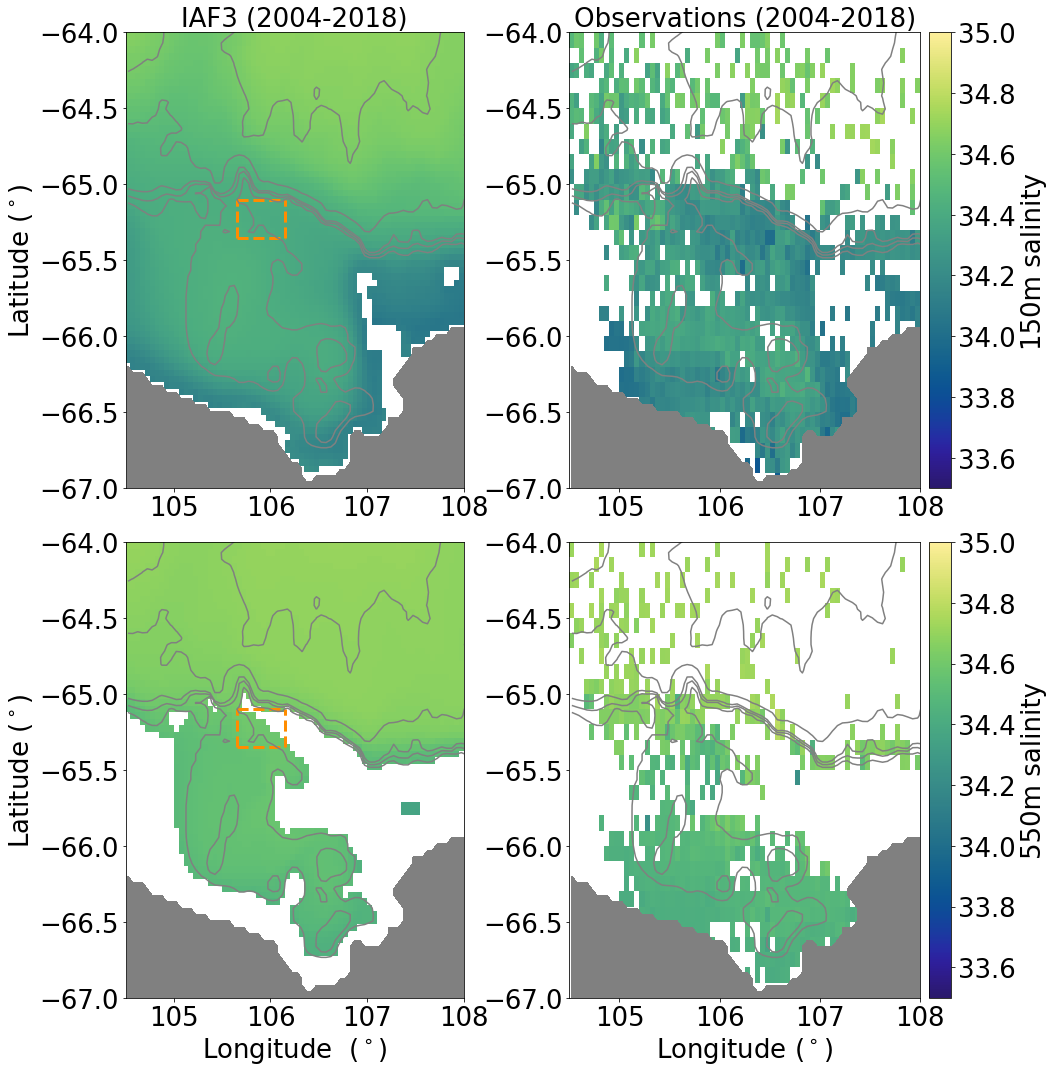

In [37]:
#Prepping variables to plot
fontsize=26

#for nt in range(0,nframes):
fig=plt.figure(figsize=(15, 15))
fig.subplots_adjust(top=0.88)
    
ax0=plt.subplot(2,2,1)   
depth_slice = 150
pc = plt.pcolormesh(sal_150m_avg.xt_ocean,sal_150m_avg.yt_ocean,
                        sal_150m_avg, cmap = cmocean.haline, 
                        vmin=33.5,vmax=35)
plt.plot([-252.7,-252.7],[-65.35, -65.1],color='darkorange',linestyle='--',linewidth=3)
plt.plot([-251.7,-251.7],[-65.35, -65.1],color='darkorange',linestyle='--',linewidth=3)
plt.plot([-252.7,-251.7],[-65.1, -65.1],color='darkorange',linestyle='--',linewidth=3)
plt.plot([-252.7,-251.7],[-65.35, -65.35],color='darkorange',linestyle='--',linewidth=3)

#plt.title('Model (2004-2018)',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[600,800,1000,2000,3000],colors='gray',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
plt.title('IAF3 (2004-2018)',fontsize=fontsize)
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
#plt.xlabel('Longitude  ($^\circ$)',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -248))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(str(depth_slice)+'m temperature from IAF3 ($^\circ$C)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-253+359,-252+359,-251+359,-250+359,-249+359,-248+359])

ax1=plt.subplot(2,2,2)    
sc=plt.pcolormesh(binned_meop_sal150.lon_bin-360,binned_meop_sal150.lat_bin,binned_meop_sal150,cmap=cmocean.haline,vmin=33.5,vmax=35)
cbar = plt.colorbar(sc, orientation = 'vertical',extend = 'neither',pad=.02)
cbar.set_label(str(depth_slice)+'m salinity',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)
#plt.title('Observations (2004-2019)',fontsize=fontsize)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[600,800,1000,2000,3000],colors='gray')
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.ylim((-67, -64))
plt.xlim((-255, -248))
plt.tick_params(labelsize=fontsize)
plt.title('Observations (2004-2018)',fontsize=fontsize)
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
#plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)

#plt.set_xticks([-255,-254,-253,-252,-251,-250,-249,-248])
ax1.set_xticklabels([-255+359,-254+359,-253+359,-252+359,-251+359,-250+359,-249+359,-248+359])

ax0=plt.subplot(2,2,3)      
depth_slice = 550
pc = plt.pcolormesh(sal_550m_avg.xt_ocean,sal_550m_avg.yt_ocean,
                        sal_550m_avg, cmap = cmocean.haline, 
                        vmin=33.5,vmax=35)
plt.plot([-252.7,-252.7],[-65.35, -65.1],color='darkorange',linestyle='--',linewidth=3)
plt.plot([-251.7,-251.7],[-65.35, -65.1],color='darkorange',linestyle='--',linewidth=3)
plt.plot([-252.7,-251.7],[-65.1, -65.1],color='darkorange',linestyle='--',linewidth=3)
plt.plot([-252.7,-251.7],[-65.35, -65.35],color='darkorange',linestyle='--',linewidth=3)

#plt.title('Model (2004-2018)',fontsize=fontsize)
        #plot contours
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[600,800,1000,2000,3000],colors='gray',linewidth=.5)
        # plot the land:
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
        # labels etc:
        #plt.xlabel('Longitude',fontsize=fontsize)
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude  ($^\circ$)',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
        #lim
plt.ylim((-67, -64))
plt.xlim((-255, -248))
        # colorbar:
cbar=plt.colorbar(pc,orientation='vertical',extend='neither')
cbar.ax.locator_params(nbins=8)
cbar.set_label(str(depth_slice)+'m temperature from IAF3 ($^\circ$C)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=20)
ax0.set_xticklabels([-255+359,-254+359,-253+359,-252+359,-251+359,-250+359,-249+359,-248+359])

ax1=plt.subplot(2,2,4)    

sc=plt.pcolormesh(binned_meop_sal550.lon_bin-360,binned_meop_sal550.lat_bin,binned_meop_sal550,cmap=cmocean.haline,vmin=33.5,vmax=35)
cbar = plt.colorbar(sc, orientation = 'vertical',extend = 'neither',pad=.02)
cbar.set_label(str(depth_slice)+'m salinity',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)
#plt.title('Observations (2004-2019)',fontsize=fontsize)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[600,800,1000,2000,3000],colors='gray')
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.ylim((-67, -64))
plt.xlim((-255, -248))
plt.tick_params(labelsize=fontsize)
#plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
#plt.set_xticks([-255,-254,-253,-252,-251,-250,-249,-248])
ax1.set_xticklabels([-255+359,-254+359,-253+359,-252+359,-251+359,-250+359,-249+359,-248+359])

# this removes colorbar whilst maintaing figure size
fig.delaxes(fig.axes[1])
fig.delaxes(fig.axes[4])

fig.tight_layout()
figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures'
filestr = figdir+'/FigS2_Figure_validation_sal.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')